# Bayesian Linear Regression

In [1]:
%pylab inline

import pandas as pd
import proplot
import pyro
from pyro.infer.autoguide import AutoDiagonalNormal
import pyro.distributions as dist
from pyro.infer import SVI
from pyro.optim import Adam

import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import torch
import torch.tensor as tensor


plt.rcParams["figure.figsize"] = (3, 3)


def std_col(df, col):
    return (df[col] - df[col].mean()) / df[col].std()


kidiq_df = pd.read_csv("../data/kidiq.csv")
# add standardized columns
kidiq_df["mom_hs_and_iq"] = kidiq_df["mom_hs"] * kidiq_df["mom_iq"]

for col in ["kid_score", "mom_hs", "mom_iq", "mom_age", "mom_hs_and_iq"]:
    kidiq_df["{}_standardized".format(col)] = std_col(kidiq_df, col)
kidiq_df.head()

Populating the interactive namespace from numpy and matplotlib


,kid_score,mom_hs,mom_iq,mom_age,mom_hs_and_iq,kid_score_standardized,mom_hs_standardized,mom_iq_standardized,mom_age_standardized,mom_hs_and_iq_standardized
0,65,1,121.117529,27,121.117529,-1.067932,0.521631,1.407835,1.560228,0.927416
1,98,1,89.361882,25,89.361882,0.548868,0.521631,-0.709208,0.819781,0.205728
2,85,1,115.443165,27,115.443165,-0.088054,0.521631,1.029544,1.560228,0.798458
3,83,1,99.449639,25,99.449639,-0.186041,0.521631,-0.036691,0.819781,0.434985
4,115,1,92.745710,27,92.745710,1.381765,0.521631,-0.483619,1.560228,0.282630


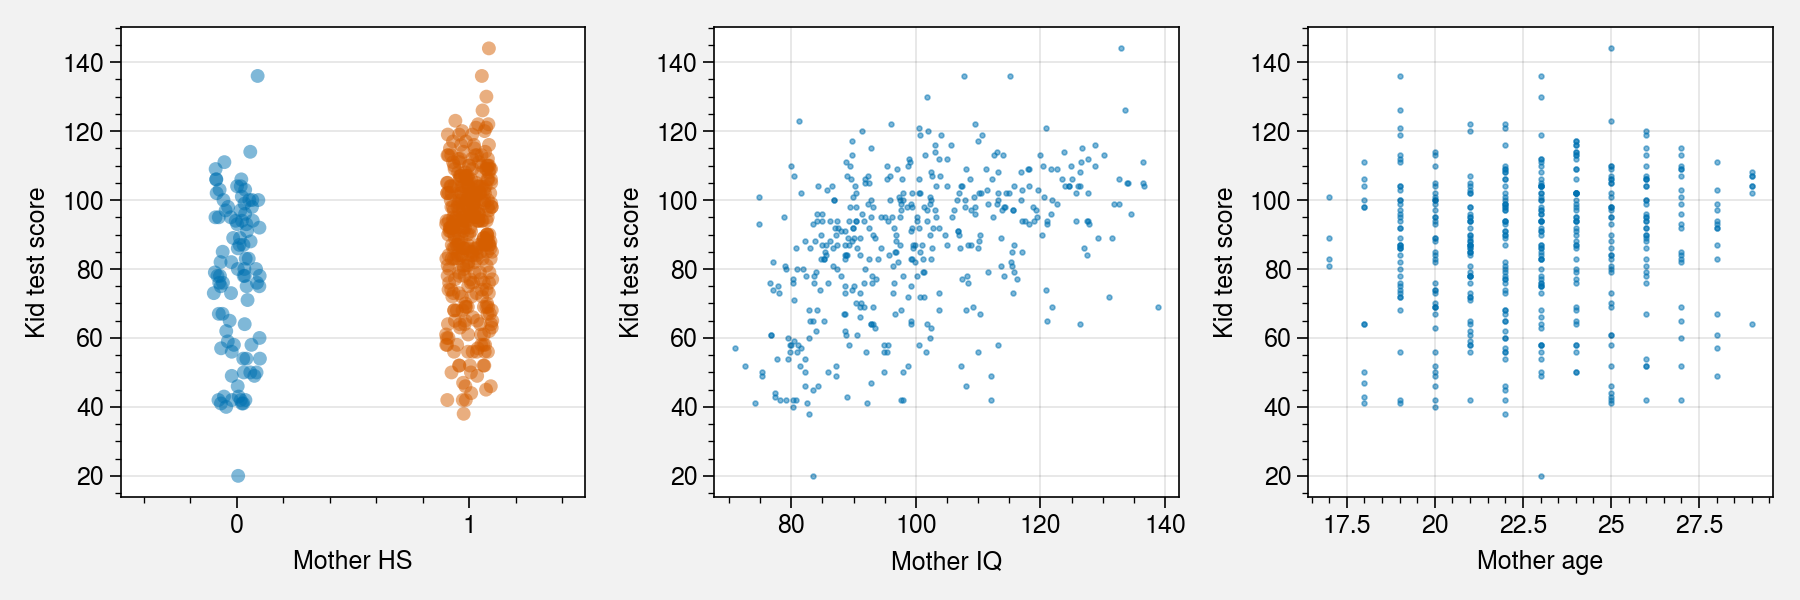

In [2]:
fig = plt.figure(figsize=(9, 3))
ax = fig.add_subplot(131)
sns.stripplot(x="mom_hs", y="kid_score", data=kidiq_df, ax=ax, alpha=0.5)
ax.set_xlabel("Mother HS")
ax.set_ylabel("Kid test score")

ax = fig.add_subplot(132)
ax.scatter(x=kidiq_df["mom_iq"], y=kidiq_df["kid_score"], alpha=0.5, s=3)
ax.set_xlabel("Mother IQ")
ax.set_ylabel("Kid test score")

ax = fig.add_subplot(133)
ax.scatter(x=kidiq_df["mom_age"], y=kidiq_df["kid_score"], alpha=0.5, s=3)
ax.set_xlabel("Mother age")
ax.set_ylabel("Kid test score")

fig.tight_layout()

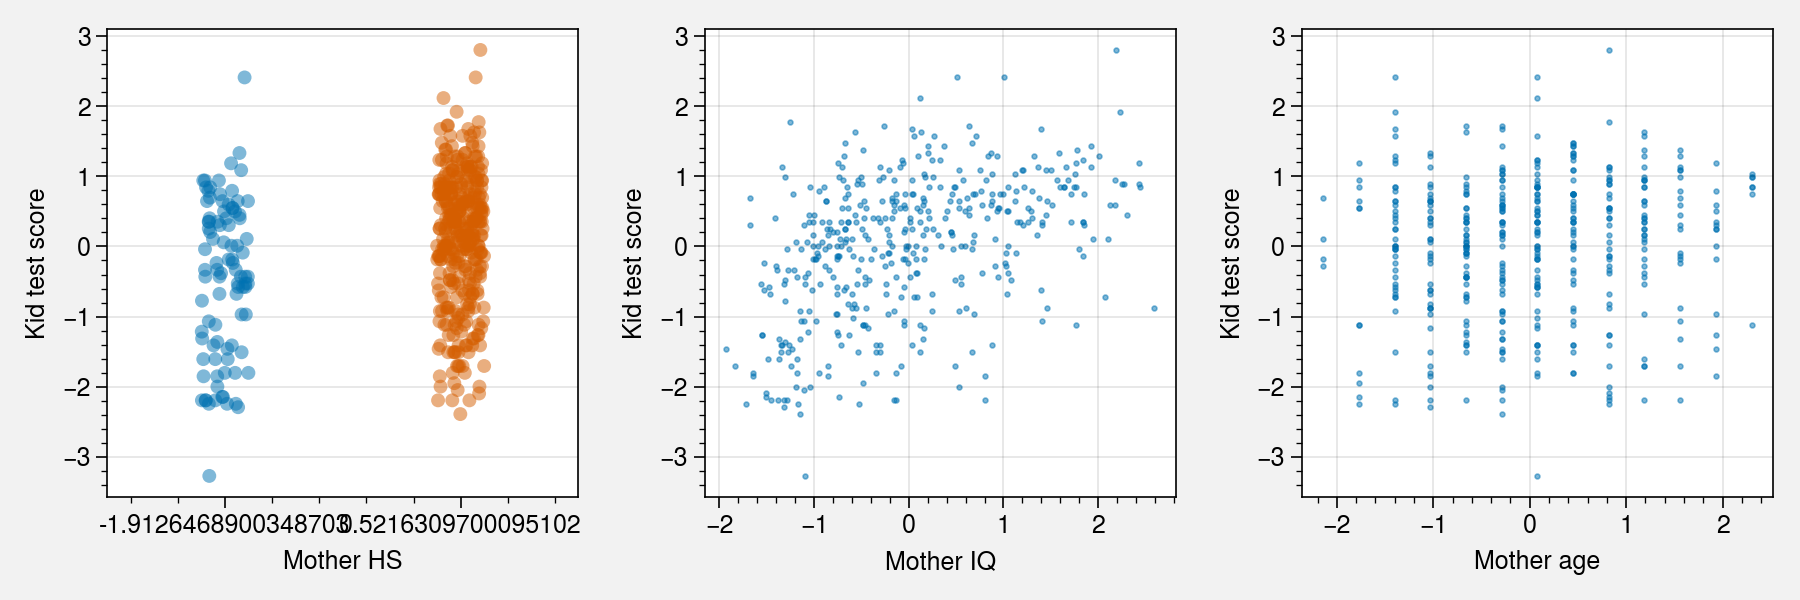

In [3]:
fig = plt.figure(figsize=(9, 3))
ax = fig.add_subplot(131)
sns.stripplot(
    x="mom_hs_standardized", y="kid_score_standardized", data=kidiq_df, ax=ax, alpha=0.5
)
ax.set_xlabel("Mother HS")
ax.set_ylabel("Kid test score")

ax = fig.add_subplot(132)
ax.scatter(
    x=kidiq_df["mom_iq_standardized"],
    y=kidiq_df["kid_score_standardized"],
    alpha=0.5,
    s=3,
)
ax.set_xlabel("Mother IQ")
ax.set_ylabel("Kid test score")

ax = fig.add_subplot(133)
ax.scatter(
    x=kidiq_df["mom_age_standardized"],
    y=kidiq_df["kid_score_standardized"],
    alpha=0.5,
    s=3,
)
ax.set_xlabel("Mother age")
ax.set_ylabel("Kid test score")

fig.tight_layout()

# Model 1: Including Mother IQ and Mother HS

In [23]:
model1 = smf.ols(formula="""kid_score ~ mom_iq + mom_hs""", data=kidiq_df)
results_hs1 = model1.fit()
print(results_hs1.summary())

                            OLS Regression Results                            
Dep. Variable:              kid_score   R-squared:                       0.214
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     58.72
Date:                Mon, 19 Oct 2020   Prob (F-statistic):           2.79e-23
Time:                        16:29:20   Log-Likelihood:                -1872.0
No. Observations:                 434   AIC:                             3750.
Df Residuals:                     431   BIC:                             3762.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     25.7315      5.875      4.380      0.0

In [22]:
model1_std = smf.ols(
    formula="""kid_score_standardized ~ mom_iq_standardized + mom_hs_standardized""",
    data=kidiq_df,
)
results_hs1_std = model1_std.fit()
print(results_hs1_std.summary())

                              OLS Regression Results                              
Dep. Variable:     kid_score_standardized   R-squared:                       0.214
Model:                                OLS   Adj. R-squared:                  0.210
Method:                     Least Squares   F-statistic:                     58.72
Date:                    Mon, 19 Oct 2020   Prob (F-statistic):           2.79e-23
Time:                            16:29:16   Log-Likelihood:                -563.03
No. Observations:                     434   AIC:                             1132.
Df Residuals:                         431   BIC:                             1144.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

# Model 2: Including Mother IQ and Mother HS and interaction

In [45]:
model2 = smf.ols(
    formula="""kid_score ~ mom_iq + mom_hs + mom_iq:mom_hs""", data=kidiq_df
)
results_hs2 = model2.fit()
print(results_hs2.summary())

                            OLS Regression Results                            
Dep. Variable:              kid_score   R-squared:                       0.230
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     42.84
Date:                Mon, 19 Oct 2020   Prob (F-statistic):           3.07e-24
Time:                        21:19:01   Log-Likelihood:                -1867.5
No. Observations:                 434   AIC:                             3743.
Df Residuals:                     430   BIC:                             3759.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -11.4820     13.758     -0.835

In [46]:
model2 = smf.ols(
    formula="""kid_score ~ mom_iq + mom_hs + mom_hs_and_iq""", data=kidiq_df
)
results_hs2 = model2.fit()
print(results_hs2.summary())

                            OLS Regression Results                            
Dep. Variable:              kid_score   R-squared:                       0.230
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     42.84
Date:                Mon, 19 Oct 2020   Prob (F-statistic):           3.07e-24
Time:                        21:19:21   Log-Likelihood:                -1867.5
No. Observations:                 434   AIC:                             3743.
Df Residuals:                     430   BIC:                             3759.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -11.4820     13.758     -0.835

In [19]:
model2_std = smf.ols(
    formula="""kid_score_standardized ~ mom_iq_standardized + mom_hs_standardized + mom_hs_standardized:mom_iq_standardized""",
    data=kidiq_df,
)
results_hs2_std = model2_std.fit()
print(results_hs2_std.summary())

                              OLS Regression Results                              
Dep. Variable:     kid_score_standardized   R-squared:                       0.230
Model:                                OLS   Adj. R-squared:                  0.225
Method:                     Least Squares   F-statistic:                     42.84
Date:                    Mon, 19 Oct 2020   Prob (F-statistic):           3.07e-24
Time:                            16:01:31   Log-Likelihood:                -558.57
No. Observations:                     434   AIC:                             1125.
Df Residuals:                         430   BIC:                             1141.
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

In [26]:
model2_std = smf.ols(
    formula="""kid_score_standardized ~ mom_iq_standardized + mom_hs_standardized + mom_hs_and_iq_standardized""",
    data=kidiq_df,
)
results_hs2_std = model2_std.fit()
print(results_hs2_std.summary())

                              OLS Regression Results                              
Dep. Variable:     kid_score_standardized   R-squared:                       0.230
Model:                                OLS   Adj. R-squared:                  0.225
Method:                     Least Squares   F-statistic:                     42.84
Date:                    Mon, 19 Oct 2020   Prob (F-statistic):           3.07e-24
Time:                            16:31:46   Log-Likelihood:                -558.57
No. Observations:                     434   AIC:                             1125.
Df Residuals:                         430   BIC:                             1141.
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

# Bayesian way

In [31]:
def BayOLS(X, y=None):
    if len(X.shape) < 2:
        X = X.unsqueeze(-1)

    bias = pyro.sample("bias", dist.Normal(0.0, 1.0))
    weight = pyro.sample("weight", dist.Normal(0, 1.0).expand((X.shape[-1],)))
    mu = pyro.deterministic("mu", X.matmul(weight) + bias)
    sigma = pyro.sample("sigma", dist.HalfCauchy(1.0))
    with pyro.plate("data", len(y)):
        response = pyro.sample("response", dist.Normal(mu, sigma), obs=y)

In [32]:
def do_BayOLS(x_cols, y_col, niter=4000):
    guide = AutoDiagonalNormal(BayOLS)
    optim = Adam({"lr": 0.001})
    svi = SVI(BayOLS, guide, optim, loss=pyro.infer.Trace_ELBO())

    pyro.clear_param_store()
    y = tensor(kidiq_df[y_col].values, dtype=torch.float)
    X = tensor(kidiq_df[x_cols].values, dtype=torch.float)
    Y_norm = (y - y.mean(0)) / y.std(0)
    X_norm = (X - X.mean(0)) / X.std(0)
    losses = []
    for n in range(niter):
        loss = svi.step(X_norm, Y_norm)
        losses.append(loss)
    return guide, losses


def summary(samples, prob=0.95):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0).data.numpy(),
            "std": torch.std(v, 0).data.numpy(),
            "{:.1f}%".format(100 * (1 - prob)): v.kthvalue(
                int(len(v) * (1 - prob)), dim=0
            )[0].data.numpy(),
            "{:.1f}%".format(100 * prob): v.kthvalue(int(len(v) * prob), dim=0)[
                0
            ].data.numpy(),
        }
    return pd.DataFrame(site_stats)

## Model1 : Bayesian

In [33]:
guide, losses = do_BayOLS(["mom_iq", "mom_hs"], "kid_score")
pred = pyro.infer.Predictive(guide, num_samples=1000)

p_summary = summary(pred.get_samples(), 0.945).loc[:, ["weight", "bias", "sigma"]]
print(p_summary)

# compare with statsmodels
print(results_hs1_std.summary())

                         weight            bias       sigma
mean   [0.40502268, 0.11577026]  -4.6634023e-07  0.89161897
std     [0.04859756, 0.0438266]     0.045083247  0.03578584
5.5%    [0.3276011, 0.05128667]    -0.070773415   0.8362434
94.5%   [0.4831033, 0.18875724]     0.072538726  0.95076054
                              OLS Regression Results                              
Dep. Variable:     kid_score_standardized   R-squared:                       0.214
Model:                                OLS   Adj. R-squared:                  0.210
Method:                     Least Squares   F-statistic:                     58.72
Date:                    Mon, 19 Oct 2020   Prob (F-statistic):           2.79e-23
Time:                            16:59:50   Log-Likelihood:                -563.03
No. Observations:                     434   AIC:                             1132.
Df Residuals:                         431   BIC:                             1144.
Df Model:                           

## Model 2: Bayesian

                                      weight          bias        sigma
mean     [0.5787375, 0.60982865, -0.5801461]  0.0031789101   0.88548845
std    [0.044318583, 0.04178921, 0.04384822]   0.039904673  0.030518401
5.5%     [0.50631094, 0.5423739, -0.6522391]   -0.06423037    0.8359176
94.5%    [0.6488661, 0.67442006, -0.5107351]   0.065484844   0.93624735
                              OLS Regression Results                              
Dep. Variable:     kid_score_standardized   R-squared:                       0.230
Model:                                OLS   Adj. R-squared:                  0.225
Method:                     Least Squares   F-statistic:                     42.84
Date:                    Mon, 19 Oct 2020   Prob (F-statistic):           3.07e-24
Time:                            17:00:30   Log-Likelihood:                -558.57
No. Observations:                     434   AIC:                             1125.
Df Residuals:                         430   BIC:           

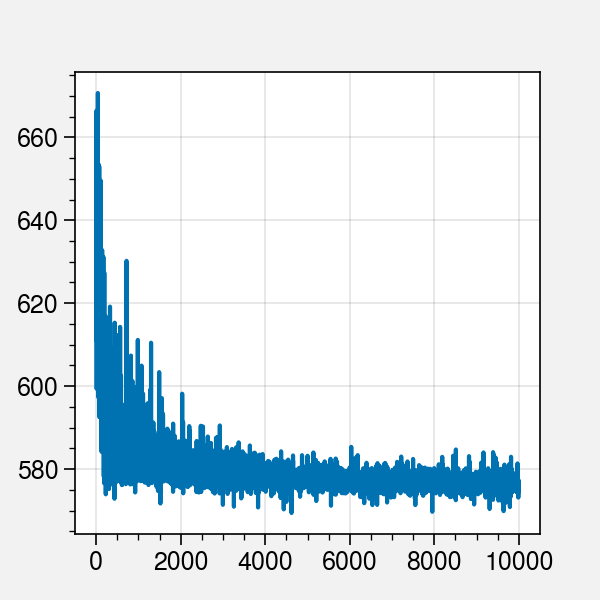

In [34]:
guide, losses = do_BayOLS(
    ["mom_iq_standardized", "mom_hs_standardized", "mom_hs_and_iq_standardized"],
    "kid_score_standardized",
    10000
)
pred = pyro.infer.Predictive(guide, num_samples=1000)
plt.plot(losses)
p_summary = summary(pred.get_samples(), 0.945).loc[:, ["weight", "bias", "sigma"]]
print(p_summary)

# compare with statsmodels
print(results_hs2_std.summary())

                                       weight          bias        sigma
mean     [0.5404348, 0.49514544, -0.45239496]  0.0020505018   0.88936365
std    [0.040621832, 0.04066392, 0.044271097]    0.04536585  0.030437753
5.5%    [0.47393703, 0.42784676, -0.52525395]   -0.06872582    0.8407479
94.5%    [0.60141975, 0.56227976, -0.3794644]    0.07489823   0.93730474
                              OLS Regression Results                              
Dep. Variable:     kid_score_standardized   R-squared:                       0.230
Model:                                OLS   Adj. R-squared:                  0.225
Method:                     Least Squares   F-statistic:                     42.84
Date:                    Mon, 19 Oct 2020   Prob (F-statistic):           3.07e-24
Time:                            17:01:00   Log-Likelihood:                -558.57
No. Observations:                     434   AIC:                             1125.
Df Residuals:                         430   BIC:      

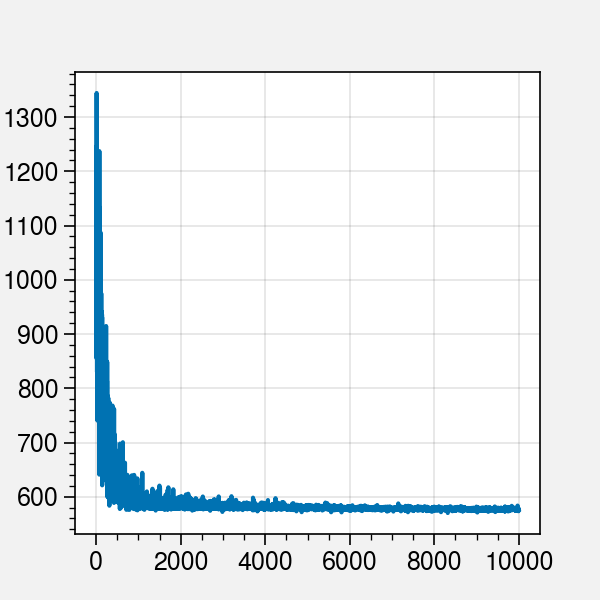

In [35]:
guide, losses = do_BayOLS(
    ["mom_iq", "mom_hs", "mom_hs_and_iq"],
    "kid_score",
    10000
)
pred = pyro.infer.Predictive(guide, num_samples=1000)
plt.plot(losses)
p_summary = summary(pred.get_samples(), 0.945).loc[:, ["weight", "bias", "sigma"]]
print(p_summary)

# compare with statsmodels
print(results_hs2_std.summary())

# Use a different guide

In [36]:
from pyro.infer.autoguide import AutoMultivariateNormal, init_to_mean

def do_BayOLSMult(x_cols, y_col, niter=4000):
    guide = AutoMultivariateNormal(BayOLS, init_loc_fn=init_to_mean)

    optim = Adam({"lr": 0.001})
    svi = SVI(BayOLS, guide, optim, loss=pyro.infer.Trace_ELBO())

    pyro.clear_param_store()
    y = tensor(kidiq_df[y_col].values, dtype=torch.float)
    X = tensor(kidiq_df[x_cols].values, dtype=torch.float)
    Y_norm = (y - y.mean(0)) / y.std(0)
    X_norm = (X - X.mean(0)) / X.std(0)
    losses = []
    for n in range(niter):
        loss = svi.step(X_norm, Y_norm)
        losses.append(loss)
    return guide, losses


                                     weight          bias       sigma
mean   [0.61155176, 0.70039403, -0.6655118]  -0.006217047  0.88417804
std    [0.09902145, 0.28772807, 0.32566673]    0.04385087  0.03518083
5.5%   [0.45061526, 0.25030747, -1.1796882]   -0.07302544  0.83006567
94.5%   [0.7689101, 1.1411662, -0.15481335]    0.06586444  0.94143176
                              OLS Regression Results                              
Dep. Variable:     kid_score_standardized   R-squared:                       0.230
Model:                                OLS   Adj. R-squared:                  0.225
Method:                     Least Squares   F-statistic:                     42.84
Date:                    Mon, 19 Oct 2020   Prob (F-statistic):           3.07e-24
Time:                            20:47:49   Log-Likelihood:                -558.57
No. Observations:                     434   AIC:                             1125.
Df Residuals:                         430   BIC:                     

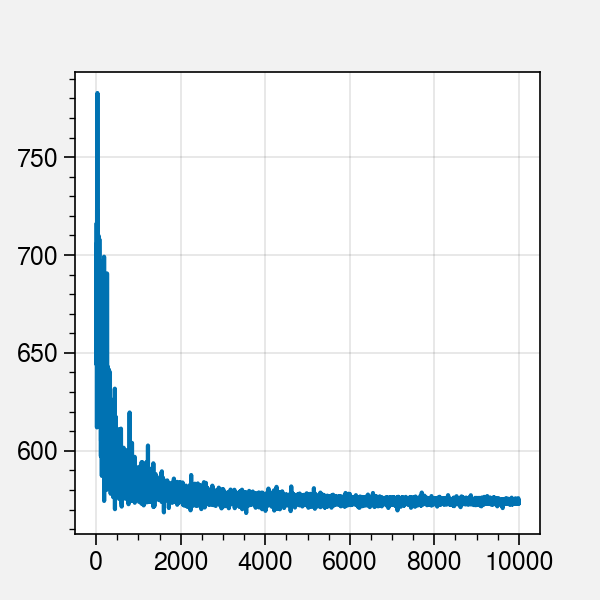

In [37]:
guide, losses = do_BayOLSMult(
    ["mom_iq_standardized", "mom_hs_standardized", "mom_hs_and_iq_standardized"],
    "kid_score_standardized",
    10000
)
pred = pyro.infer.Predictive(guide, num_samples=1000)
plt.plot(losses)
p_summary = summary(pred.get_samples(), 0.945).loc[:, ["weight", "bias", "sigma"]]
print(p_summary)

# compare with statsmodels
print(results_hs2_std.summary())

# Use MCMC

In [42]:
from pyro.infer import MCMC, NUTS

# ["mom_iq_standardized", "mom_hs_standardized", "mom_hs_and_iq_standardized"],
#    "kid_score_standardized",
nuts_kernel = NUTS(BayOLS)

mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200)

x_cols = ["mom_iq_standardized", "mom_hs_standardized", "mom_hs_and_iq_standardized"]
y_col = "kid_score_standardized"
y = tensor(kidiq_df[y_col].values, dtype=torch.float)
X = tensor(kidiq_df[x_cols].values, dtype=torch.float)
pyro.clear_param_store()

mcmc.run(X,
         y    )
p_summary = summary(mcmc.get_samples(), 0.945).loc[:, ["weight", "bias", "sigma"]]
print(p_summary)

Sample: 100%|██████████| 1200/1200 [01:16, 15.72it/s, step size=1.47e-01, acc. prob=0.923]

                                     weight          bias      sigma
mean   [0.65107846, 0.83828115, -0.8262416]  0.0018113627  0.8828635
std     [0.09594637, 0.2654418, 0.30107254]    0.04035751  0.0286265
5.5%   [0.49300468, 0.41385654, -1.3155348]   -0.06273111  0.8389928
94.5%   [0.8077668, 1.2664745, -0.36087024]   0.069480196  0.9336156


In [44]:
x_cols = ["mom_iq", "mom_hs", "mom_hs_and_iq"]
y_col = "kid_score"
y = tensor(kidiq_df[y_col].values, dtype=torch.float)
X = tensor(kidiq_df[x_cols].values, dtype=torch.float)
pyro.clear_param_store()

mcmc.run(X,
         y    )
p_summary = summary(mcmc.get_samples(), 0.945).loc[:, ["weight", "bias", "sigma"]]
print(p_summary)

Sample: 100%|██████████| 1200/1200 [01:24, 14.26it/s, step size=2.59e-01, acc. prob=0.942]

                                       weight        bias      sigma
mean      [0.837772, 0.70274615, 0.015344702]  0.70172584  18.646265
std     [0.021960413, 0.9837774, 0.023600714]   0.9971226  0.6514424
5.5%   [0.8042504, -0.88002384, -0.023354093]  -0.8661515  17.615824
94.5%     [0.87434566, 2.2254558, 0.05152584]   2.2737036  19.680378


In [53]:
def BayOLS(X, y=None):
    if len(X.shape) < 2:
        X = X.unsqueeze(-1)

    bias = pyro.sample("bias", dist.Normal(0.0, 100.0))
    weight = pyro.sample("weight", dist.Normal(0, 100.0).expand((X.shape[-1],)))
    mu = pyro.deterministic("mu", X.matmul(weight) + bias)
    sigma = pyro.sample("sigma", dist.HalfCauchy(100.0))
    with pyro.plate("data", len(y)):
        response = pyro.sample("response", dist.Normal(mu, sigma), obs=y)

In [54]:
x_cols = ["mom_iq", "mom_hs", "mom_hs_and_iq"]
y_col = "kid_score"
y = tensor(kidiq_df[y_col].values, dtype=torch.float)
X = tensor(kidiq_df[x_cols].values, dtype=torch.float)
nuts_kernel = NUTS(BayOLS)

mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200)
pyro.clear_param_store()

mcmc.run(X,
         y    )
p_summary = summary(mcmc.get_samples(), 0.945).loc[:, ["weight", "bias", "sigma"]]
print(p_summary)

Sample: 100%|██████████| 1200/1200 [05:27,  3.66it/s, step size=2.63e-02, acc. prob=0.928]

                                    weight        bias       sigma
mean    [0.9570536, 50.01448, -0.47146818]  -10.313735   17.967796
std    [0.13849212, 14.610381, 0.15276073]   12.955309  0.56566155
5.5%   [0.7268036, 26.256752, -0.71574265]  -31.315405   17.042994
94.5%    [1.174563, 72.92132, -0.22256066]   10.187715    18.89629


In [56]:
print(results_hs2.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.225    
Dependent Variable: kid_score        AIC:                3743.0857
Date:               2020-10-19 23:49 BIC:                3759.3779
No. Observations:   434              Log-Likelihood:     -1867.5  
Df Model:           3                F-statistic:        42.84    
Df Residuals:       430              Prob (F-statistic): 3.07e-24 
R-squared:          0.230            Scale:              322.97   
------------------------------------------------------------------
                  Coef.   Std.Err.    t    P>|t|   [0.025   0.975]
------------------------------------------------------------------
Intercept        -11.4820  13.7580 -0.8346 0.4044 -38.5233 15.5592
mom_iq             0.9689   0.1483  6.5314 0.0000   0.6773  1.2605
mom_hs            51.2682  15.3376  3.3427 0.0009  21.1223 81.4142
mom_hs_and_iq     -0.4843   0.1622 -2.9853 0.0030  -0.8031 -0.1654
-------------

Hence the choicof variance determines how flexible the coefficients can be. Try the above with a variance 
of 1 or 10.